In [1]:
from pathlib import Path
import itertools
from functools import reduce

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm


from lobib import DataLoader

sns.set_style("whitegrid")
rng = np.random.default_rng(1337)

In [2]:
loader = DataLoader()

def pl_select(condlist: list[pl.Expr], choicelist: list[pl.Expr]) -> pl.Expr:
    return reduce(
        lambda expr, cond_choice: expr.when(cond_choice[0]).then(cond_choice[1]),
        zip(condlist, choicelist),
        pl.when(condlist[0]).then(choicelist[0]),
    )

def imbalance_exp() -> tuple[pl.Expr, pl.Expr]:
    condlist = [pl.col("best_bid_nbr").eq(-i) for i in range(1, 11)]
    choicelist = [pl.col(f"Q_{-i}") for i in range(1, 11)]
    best_bid = pl_select(condlist, choicelist).alias("best_bid").truediv(500).ceil()
    
    condlist = [pl.col("best_ask_nbr").eq(i) for i in range(1, 11)]
    choicelist = [pl.col(f"Q_{i}") for i in range(1, 11)]
    best_ask = pl_select(condlist, choicelist).alias("best_ask").truediv(500).ceil()
    imb = ((best_bid - best_ask) / (best_bid + best_ask)).alias("imb")

    bins = np.arange(11, step=1) / 10
    condlist = [
        *[
            pl.col("imb").ge(left) & pl.col("imb").lt(right)
            for left, right in zip(-bins[1:][::-1], -bins[:-1][::-1])
        ],
        pl.col("imb").eq(0),
        *[
            pl.col("imb").gt(left) & pl.col("imb").le(right)
            for left, right in zip(bins[:-1], bins[1:])
        ],
    ]
    choicelist = [*(-bins[1:][::-1]), 0, *bins[1:]]
    imb_bin = pl_select(condlist, choicelist).alias("imb_bin")
    return imb, imb_bin
    
def load_ticker(ticker: str) -> pl.DataFrame:
    info = loader.ticker_info("AAL")
    df = loader.load(
        "AAL",
        start_date=info["date"].min(),
        end_date=info["date"].max(),
        schema="qr",
        eager=True,
    ).sort(["date", "ts_event"])
    df = df.filter(
        (
            pl.col("event_side")
            .replace({"A": 1, "B": -1})
            .cast(int)
            .mul(pl.col("event_queue_nbr"))
            >= 0
        )
    )
    df = df.with_columns(pl.col("event").replace({"Trd_All": "Trd"}))
    df = df.with_columns(
        pl.when(pl.col("event_queue_nbr").lt(0))
        .then(pl.col("event_queue_nbr").sub(pl.col("best_bid_nbr")).sub(1))
        .otherwise(pl.col("event_queue_nbr").sub(pl.col("best_ask_nbr")).add(1))
        .alias("event_q")
    )
    imb, imb_bin = imbalance_exp()
    df = df.with_columns(imb).with_columns(imb_bin)
    df = df.filter(pl.col("event_q").abs().le(2))
    df = df.with_columns(pl.when(pl.col("spread").ge(2)).then(2).otherwise(pl.col("spread")).alias("spread"))
    return df 

def compute_dt(df: pl.DataFrame) -> pl.DataFrame:
    dt = df.select(pl.col("ts_event").diff().over("date").cast(int).alias("dt"), "imb_bin", "spread").filter(pl.col("dt").gt(0))
    dt = dt.with_columns(pl.col("dt").log10().alias("dt_log"))
    return dt

In [3]:
ticker = "AAL"
df = load_ticker(ticker)
dt = compute_dt(df)

In [4]:
DAY_NS = int(5.5 * 3600 * 1e9)  # 5.5 hours in nanoseconds
HOUR_NS = int(3600 * 1e9)

dfer = pl.read_parquet("../data/results/result_alpha_ema_impact_k1.0_race.parquet")
dfer = dfer.with_columns(
  (pl.col("ts_event") // DAY_NS).alias("date")
)
dfe = dfer.filter(~pl.col("rejected"))
imb, imb_bin = imbalance_exp()
dfe = dfe.with_columns(imb_bin)

In [5]:
dte = dfe.select(pl.col("ts_event").diff().alias("dt")).filter(pl.col("dt").gt(0)).with_columns(pl.col("dt").log10().alias("dt_log"))

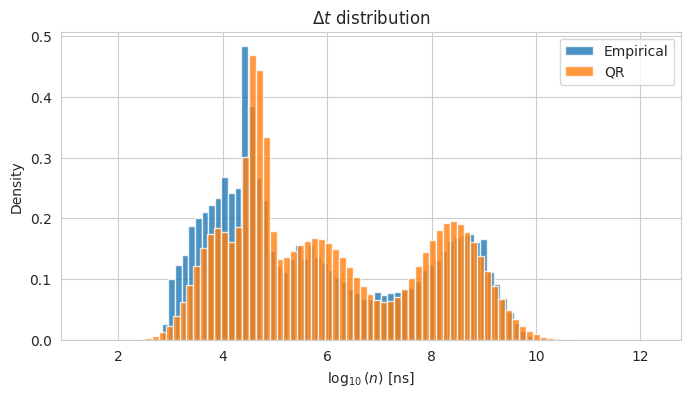

In [6]:
plt.figure(figsize=(8, 4))

plt.hist(dt["dt_log"], bins=80, label="Empirical", density=True, alpha=.8)
plt.hist(dte["dt_log"], bins=80, label="QR", density=True, alpha=.8)

plt.ylabel("Density")
plt.xlabel(r"$\log_{10}(n)\text{ [ns] }$")
plt.title(r"$\Delta t$ distribution")
plt.legend()
plt.show()

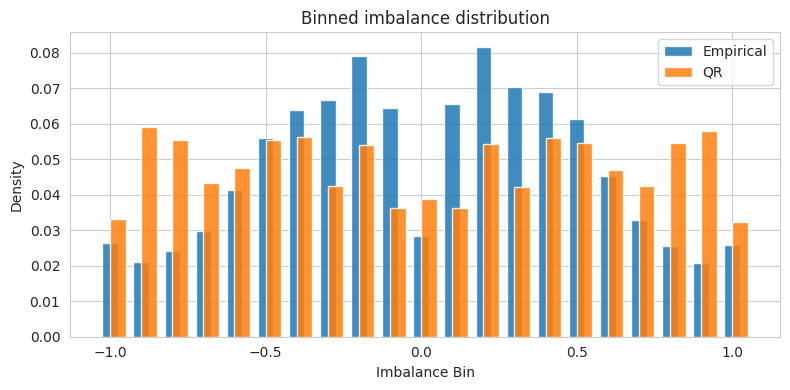

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))

imbf = df["imb_bin"].value_counts(normalize=True).sort("imb_bin")
imbfe = dfe["imb_bin"].value_counts(normalize=True).sort("imb_bin")

x = imbf["imb_bin"]
width = 0.05

ax.bar(x, imbf["proportion"], width, label="Empirical", alpha=0.85)
ax.bar(x + width/2, imbfe["proportion"], width, label="QR", alpha=0.85)

ax.set_xlabel("Imbalance Bin")
ax.set_ylabel("Density")
ax.legend()
ax.set_title("Binned imbalance distribution")

plt.tight_layout()
plt.show()

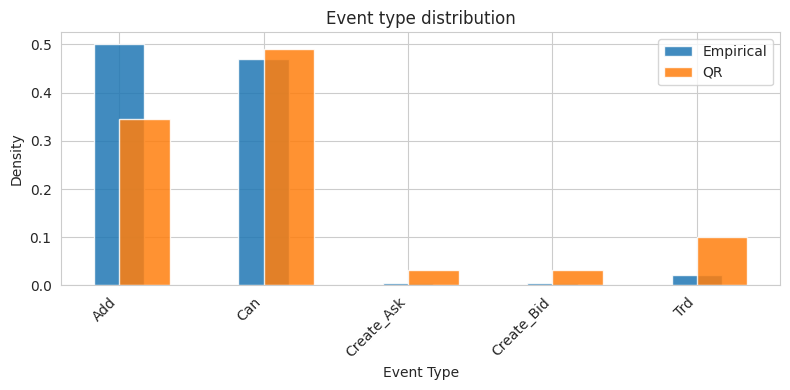

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))

imbf = df["event"].value_counts(normalize=True).sort("event")
imbfe = dfe["event"].value_counts(normalize=True).sort("event")

labels = imbf["event"]
x = np.arange(len(labels))
width = 0.35

ax.bar(x , imbf["proportion"], width, label="Empirical", alpha=0.85)
ax.bar(x + width/2, imbfe["proportion"], width, label="QR", alpha=0.85)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel("Event Type")
ax.set_ylabel("Density")
ax.legend()
ax.set_title("Event type distribution")

plt.tight_layout()

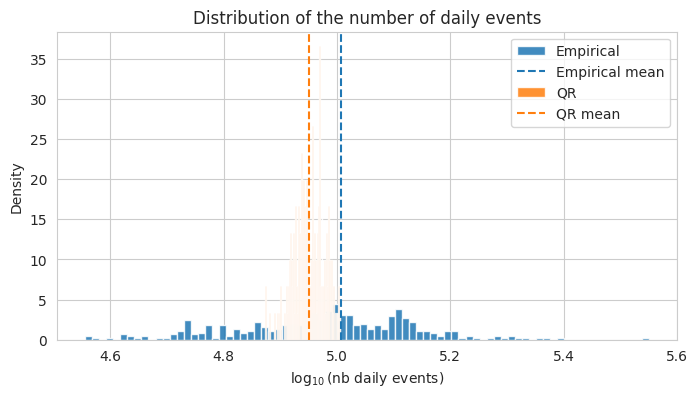

In [9]:
plt.figure(figsize=(8, 4))

plt.hist(df.group_by("date").len().with_columns(pl.col("len").log10())["len"], bins=80, label="Empirical", alpha=.85, density=True)
plt.axvline(np.log10(df.group_by("date").len()["len"].mean()), label="Empirical mean", linestyle="--")
plt.hist(dfe.group_by("date").len().with_columns(pl.col("len").log10())["len"], bins=80, label="QR", alpha=.85, density=True)
plt.axvline(np.log10(dfe.group_by("date").len()["len"].mean()), label="QR mean", linestyle="--", color="tab:orange")


plt.title("Distribution of the number of daily events")
plt.xlabel(r"$\log_{10}(\text{nb daily events})$")
plt.ylabel("Density")
plt.legend()
plt.show()

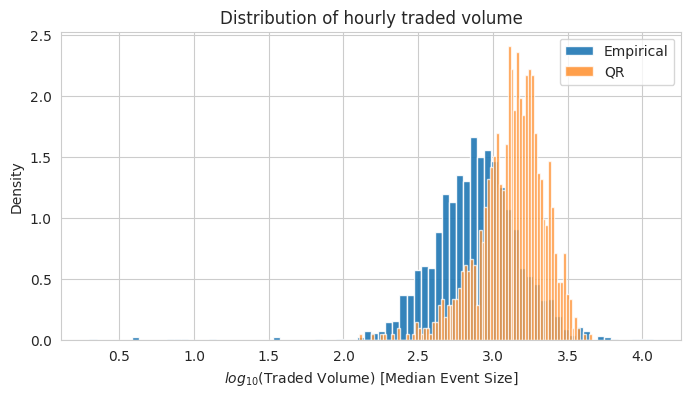

In [10]:
plt.figure(figsize=(8, 4))

sz = df.filter(pl.col("event").eq("Trd")).group_by(pl.col("date"), pl.col("ts_event").dt.hour()).agg(pl.col("event_size").truediv(500).ceil().cast(int).sum())["event_size"]
sze = dfe.filter(pl.col("event").eq("Trade")).group_by(pl.col("date"), pl.col("ts_event")//HOUR_NS).agg(pl.col("event_size").truediv(500).ceil().cast(int).sum())["event_size"]

plt.hist(sz.log10(), bins=80, label="Empirical", alpha=.9, density=True)
plt.hist(sze.log10(), bins=80, label="QR", alpha=.75, density=True)

plt.title("Distribution of hourly traded volume")
plt.xlabel(r"$log_{10}(\text{Traded Volume})$ [Median Event Size]")
plt.ylabel("Density")
plt.legend()
plt.show()